# Data exploration and preparation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import seaborn as sns
import os
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from skimage.feature import hog
from skimage import exposure

In [3]:
train_images_path = r"csvTrainImages 13440x1024.csv"
train_labels_path = 'csvTrainLabel 13440x1.csv'
test_images_path  = 'csvTestImages 3360x1024.csv'
test_labels_path  = 'csvTestLabel 3360x1.csv'

X_train = pd.read_csv(train_images_path, header=None).values     
y_train = pd.read_csv(train_labels_path, header=None).iloc[:,0].values  
X_test  = pd.read_csv(test_images_path,  header=None).values    
y_test  = pd.read_csv(test_labels_path,  header=None).iloc[:,0].values 
#y_train-=1
#y_test-=1
print(f"Training set:  X={X_train.shape}, y={y_train.shape}")
print(f"Test     set:  X={X_test.shape},  y={y_test.shape}")


Training set:  X=(13440, 1024), y=(13440,)
Test     set:  X=(3360, 1024),  y=(3360,)


In [4]:
arabic_letters = [
    'ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س',
    'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م',
    'ن', 'ه', 'و', 'ي'
]

Number of unique classes: 28

Training samples per class:
ا    480
ب    480
ت    480
ث    480
ج    480
ح    480
خ    480
د    480
ذ    480
ر    480
ز    480
س    480
ش    480
ص    480
ض    480
ط    480
ظ    480
ع    480
غ    480
ف    480
ق    480
ك    480
ل    480
م    480
ن    480
ه    480
و    480
ي    480
dtype: int64


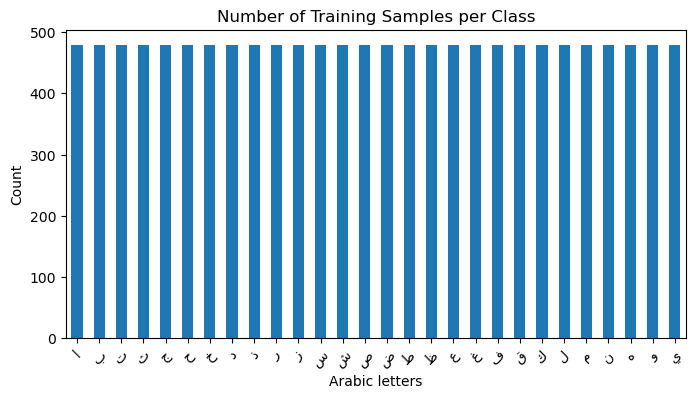

In [5]:
unique_classes, counts = np.unique(y_train, return_counts=True)
print(f"Number of unique classes: {len(unique_classes)}\n")

# Build a pandas Series for easy display
dist = pd.Series(counts, index=[arabic_letters[i - 1] for i in unique_classes])
print("Training samples per class:")
print(dist)

plt.figure(figsize=(8,4))
dist.plot(kind='bar')
plt.title("Number of Training Samples per Class")
plt.xlabel("Arabic letters")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()


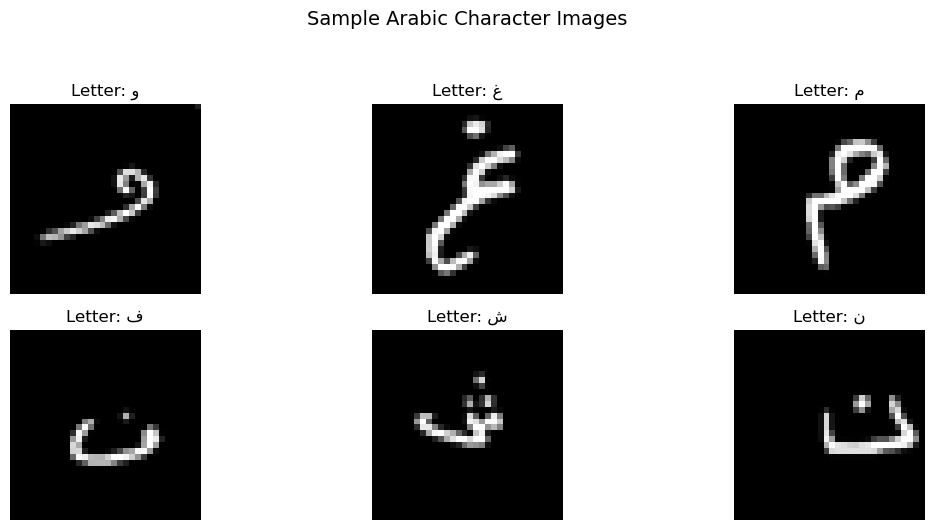

In [6]:
def show_arabic_image(flat_vec, label=None, img_shape=(32, 32), cmap='gray'):
    img = flat_vec.reshape(img_shape)
    img = np.flipud(img)  
    img = img.T           
    img = np.fliplr(img)  
    
    plt.imshow(img, cmap=cmap)
    if label is not None:
        plt.title(f"Letter: {arabic_letters[label]}", fontsize=12)
    plt.axis('off')
indices = np.random.choice(len(X_train), size=6)
plt.figure(figsize=(12, 5))
for i, idx in enumerate(indices):
    plt.subplot(2, 3, i+1)
    show_arabic_image(X_train[idx], y_train[idx] - 1)
plt.suptitle("Sample Arabic Character Images", y=1.05, fontsize=14)
plt.tight_layout()
plt.show()

In [7]:
#normalize 
X_train_norm = X_train.astype(np.float32) / 255.0
X_test_norm  = X_test.astype(np.float32)  / 255.0
print("Pixel value range after normalization:",
      X_train_norm.min(), "to", X_train_norm.max())


Pixel value range after normalization: 0.0 to 1.0


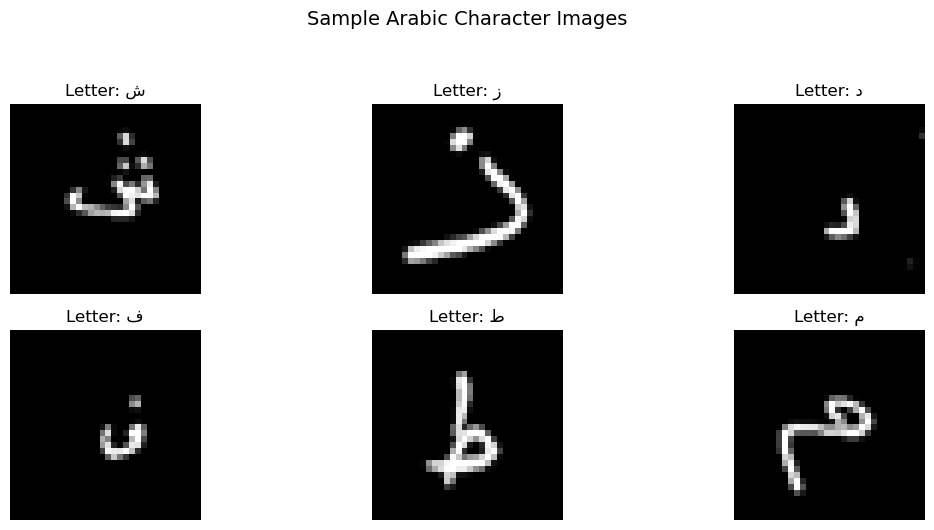

In [8]:
def show_arabic_image(flat_vec, label=None, img_shape=(32, 32), cmap='gray'):
    img = flat_vec.reshape(img_shape)
    img = np.flipud(img)  
    img = img.T           
    img = np.fliplr(img)  
    
    plt.imshow(img, cmap=cmap)
    if label is not None:
        plt.title(f"Letter: {arabic_letters[label]}", fontsize=12)
    plt.axis('off')
indices = np.random.choice(len(X_train_norm), size=6)
plt.figure(figsize=(12, 5))
for i, idx in enumerate(indices):
    plt.subplot(2, 3, i+1)
    show_arabic_image(X_train_norm[idx], y_train[idx] - 1)
plt.suptitle("Sample Arabic Character Images", y=1.05, fontsize=14)
plt.tight_layout()
plt.show()

# First experiment (SVM)

In [9]:
model = svm.SVC()
model.fit(X_train, y_train.ravel())
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy (SVM):", accuracy)

Test Accuracy (SVM): 0.6529761904761905


In [10]:
def extract_hog_features(images):
    hog_features = []
    for img in images:
        img_reshaped = img.reshape((32, 32))
        features = hog(img_reshaped, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
        hog_features.append(features)
    return np.array(hog_features)

X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

In [11]:
svm_model = SVC(kernel='rbf', C=10, gamma=0.01)
svm_model.fit(X_train_hog, y_train.ravel())

y_pred = svm_model.predict(X_test_hog)
svm_accuracy = accuracy_score(y_test, y_pred)
print("SVM with HOG Accuracy:", svm_accuracy)

SVM with HOG Accuracy: 0.7300595238095238


# Second experiment (Neural Networks)

* First Model

In [12]:

print("Unique labels in y_train:", np.unique(y_train))
print("Label range:", min(y_train), "-", max(y_train))
y_train_0indexed = y_train - 1  
y_test_0indexed = y_test - 1

print("After conversion:")
print("Unique labels in y_train_0indexed:", np.unique(y_train_0indexed))
print("Label range:", min(y_train_0indexed), "-", max(y_train_0indexed))

num_classes = max(y_train_0indexed) + 1
print("Number of classes:", num_classes)


y_train_cat = to_categorical(y_train_0indexed, num_classes=num_classes)
y_test_cat = to_categorical(y_test_0indexed, num_classes=num_classes)

print("Shape of y_train_cat:", y_train_cat.shape)
print("Shape of y_test_cat:", y_test_cat.shape)

Unique labels in y_train: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
Label range: 1 - 28
After conversion:
Unique labels in y_train_0indexed: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
Label range: 0 - 27
Number of classes: 28
Shape of y_train_cat: (13440, 28)
Shape of y_test_cat: (3360, 28)


In [13]:
def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(32,32,1)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

* second Model

In [14]:
def create_deeper_cnn_model():
    model = Sequential([
        Conv2D(64, (3,3), activation='relu', input_shape=(32,32,1)),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(256, (3,3), activation='relu'),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
models = [create_cnn_model, create_deeper_cnn_model]
model_names = ["CNN", "Deeper CNN"]
model_results = []

for model_func, name in zip(models, model_names):
    print(f"\n--- Evaluating {name} with {k}-fold CV ---")
    fold_accuracies = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_norm)):
        print(f"\nFold {fold + 1}/{k}")
        X_train_fold, X_val_fold = X_train_norm[train_idx], X_train_norm[val_idx]
        y_train_fold, y_val_fold = y_train_cat[train_idx], y_train_cat[val_idx]
        model = model_func()
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        X_train_fold_reshaped = X_train_fold.reshape(-1, 32, 32, 1)
        X_val_fold_reshaped = X_val_fold.reshape(-1, 32, 32, 1)

        history = model.fit(
            X_train_fold_reshaped, y_train_fold,
            validation_data=(X_val_fold_reshaped, y_val_fold),
            epochs=30,
            batch_size=128,
            callbacks=[early_stop],
            verbose=1
        )
        val_loss, val_acc = model.evaluate(X_val_fold_reshaped, y_val_fold, verbose=0)
        fold_accuracies.append(val_acc)
        print(f"Fold {fold + 1} Validation Accuracy: {val_acc:.4f}")
    
        avg_acc = np.mean(fold_accuracies)
        model_results.append((name, avg_acc, model_func))
        print(f"\n{name} Average Validation Accuracy: {avg_acc:.4f}")




--- Evaluating CNN with 5-fold CV ---

Fold 1/5
Epoch 1/30


c:\Users\lenovo\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.1410 - loss: 2.9972 - val_accuracy: 0.5033 - val_loss: 1.7372
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.4387 - loss: 1.7911 - val_accuracy: 0.6819 - val_loss: 1.0702
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.5953 - loss: 1.2331 - val_accuracy: 0.7578 - val_loss: 0.7948
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.6852 - loss: 0.9569 - val_accuracy: 0.8021 - val_loss: 0.6424
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.7416 - loss: 0.7679 - val_accuracy: 0.8229 - val_loss: 0.5545
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.7859 - loss: 0.6592 - val_accuracy: 0.8497 - val_loss: 0.4880
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8083 - loss: 0.5708 - val_accuracy: 0.8534 - val_loss: 0.4535
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8272 - loss: 0.5106 - val_accuracy: 0.8646 - val_loss: 0.

In [16]:
best_model_name, best_acc, best_model_func = max(model_results, key=lambda x: x[1])
print(f"\nBest model: {best_model_name} with average validation accuracy: {best_acc:.4f}")



Best model: Deeper CNN with average validation accuracy: 0.9410


In [17]:
print(f"\nTraining {best_model_name} on full training set...")
X_train_fold_reshaped = X_train_fold.reshape(-1, 32, 32, 1)
X_val_fold_reshaped = X_val_fold.reshape(-1, 32, 32, 1)
best_model=best_model_func()
history = best_model.fit(
            X_train_fold_reshaped, y_train_fold,
            validation_data=(X_val_fold_reshaped, y_val_fold),
            epochs=30,
            batch_size=128,
            callbacks=[early_stop],
            verbose=1
        )


Training Deeper CNN on full training set...
Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 160ms/step - accuracy: 0.2140 - loss: 2.6442 - val_accuracy: 0.6611 - val_loss: 0.9864
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 0.6720 - loss: 0.9721 - val_accuracy: 0.8017 - val_loss: 0.6111
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 0.7990 - loss: 0.5928 - val_accuracy: 0.8512 - val_loss: 0.4349
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 0.8596 - loss: 0.4221 - val_accuracy: 0.8828 - val_loss: 0.3476
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 0.8901 - loss: 0.3160 - val_accuracy: 0.9010 - val_loss: 0.3033
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9231 - loss: 0.2311 - val_accuracy: 0.9074 - val_loss: 0.2656
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 0.9373 - loss: 0.1847 - val_accuracy: 0.8940 - val_loss: 0.3066
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step

In [18]:
X_test_norm_reshaped = X_test_norm.reshape(-1, 32, 32, 1)
test_loss, test_acc = best_model.evaluate(X_test_norm_reshaped, y_test_cat, verbose=0)
print(f"\nBest Model Test Accuracy: {test_acc:.4f}")


Best Model Test Accuracy: 0.9503


105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


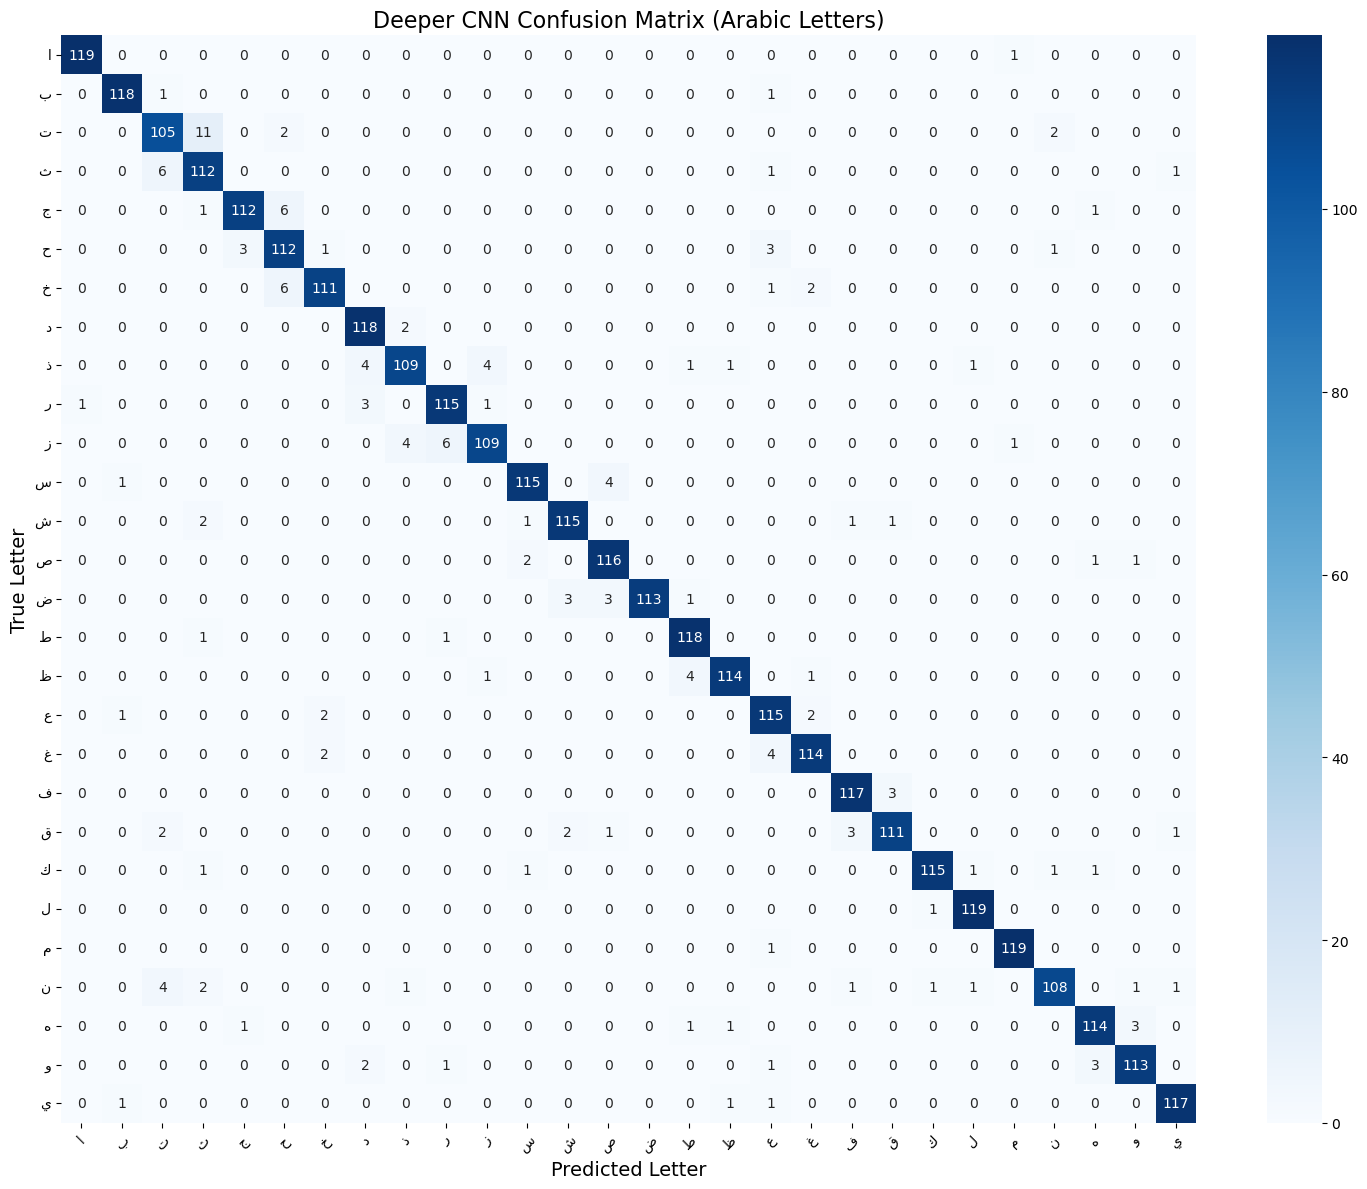

In [19]:
y_pred_nn = best_model.predict(X_test_norm_reshaped)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)
cm_nn = confusion_matrix(y_test_0indexed, y_pred_nn_classes)

plt.figure(figsize=(15, 12))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues',
            xticklabels=arabic_letters,
            yticklabels=arabic_letters)
plt.title(f'{best_model_name} Confusion Matrix (Arabic Letters)', fontsize=16)
plt.xlabel('Predicted Letter', fontsize=14)
plt.ylabel('True Letter', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [20]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 30, 30, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 28)             │        14,364 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,445,078 (28.40 MB)

 Trainable params: 2,481,692 (9.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,963,386 (18.93 MB)

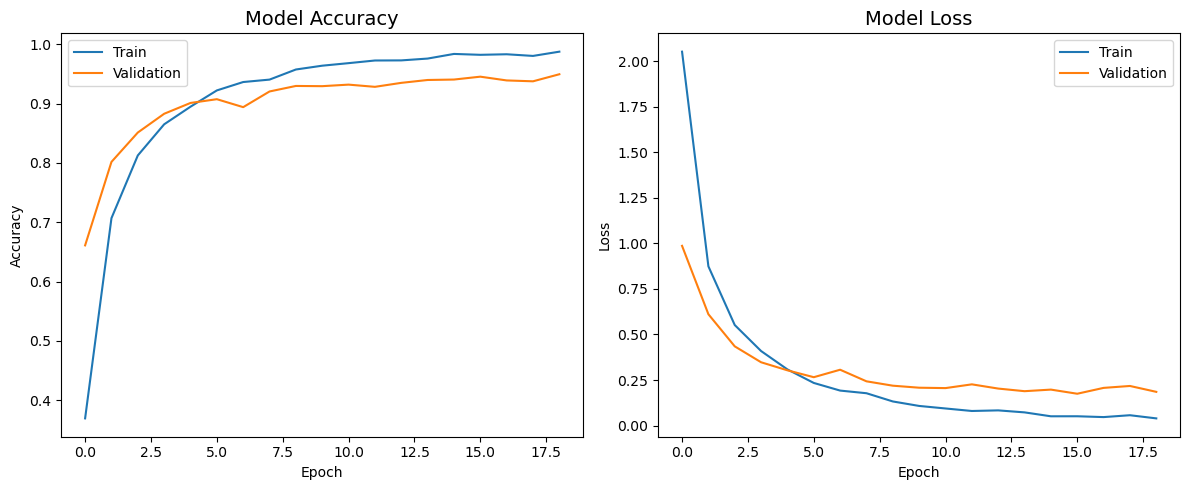

In [21]:

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy', fontsize=14)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss', fontsize=14)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
standard_cnn = create_cnn_model()
standard_cnn.fit(
    X_train_fold_reshaped, y_train_fold,
    validation_data=(X_val_fold_reshaped, y_val_fold),
    epochs=30,
    batch_size=128,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
    verbose=1
)

Epoch 1/30


c:\Users\lenovo\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.1567 - loss: 2.9206 - val_accuracy: 0.5290 - val_loss: 1.6089
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4935 - loss: 1.5932 - val_accuracy: 0.6923 - val_loss: 1.0085
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.6397 - loss: 1.0936 - val_accuracy: 0.7690 - val_loss: 0.7408
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7187 - loss: 0.8177 - val_accuracy: 0.8065 - val_loss: 0.5959
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.7764 - loss: 0.6656 - val_accuracy: 0.8404 - val_loss: 0.5096
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.8075 - loss: 0.5799 - val_accuracy: 0.8490 - val_loss: 0.4648
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.8269 - loss: 0.5103 - val_accuracy: 0.8638 - val_loss: 0.4090
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8548 - loss: 0.4277 - val_accuracy: 0.8798 - val_loss: 0.

In [23]:
standard_test_loss, standard_test_acc = standard_cnn.evaluate(X_test_norm_reshaped, y_test_cat, verbose=0)
print(f"\nModel Test Accuracy: {standard_test_acc:.4f}")


Model Test Accuracy: 0.9256


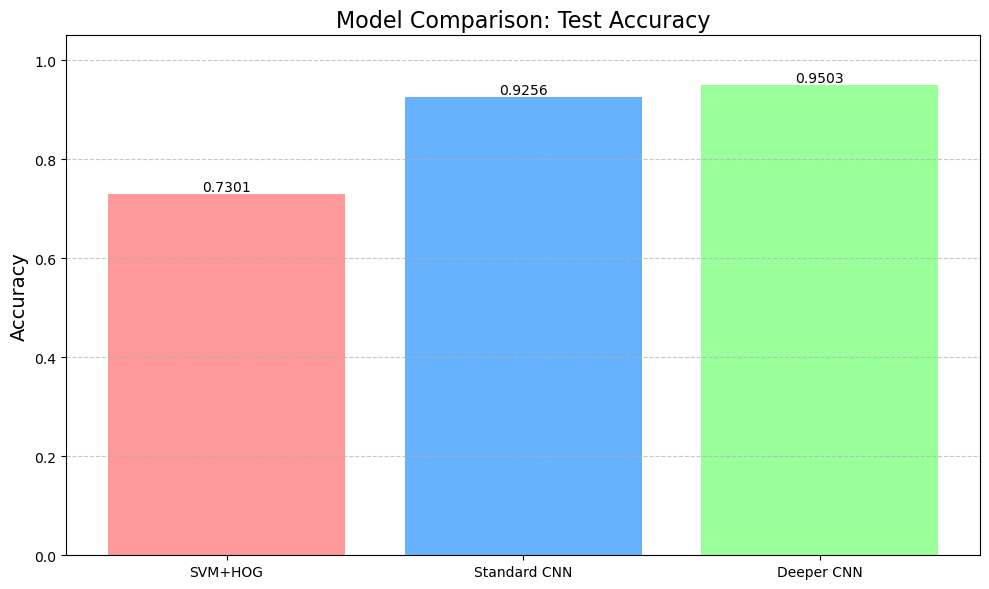

In [29]:
plt.figure(figsize=(10, 6))
models = ['SVM+HOG', 'Standard CNN', 'Deeper CNN']
accuracies = [svm_accuracy, standard_test_acc, test_acc]
colors = ['#FF9999', '#66B2FF', '#99FF99']

bars = plt.bar(models, accuracies, color=colors)

# Add accuracy labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
            f'{height:.4f}', ha='center', va='bottom')

plt.title('Model Comparison: Test Accuracy', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('full_model_comparison.png')
plt.show()

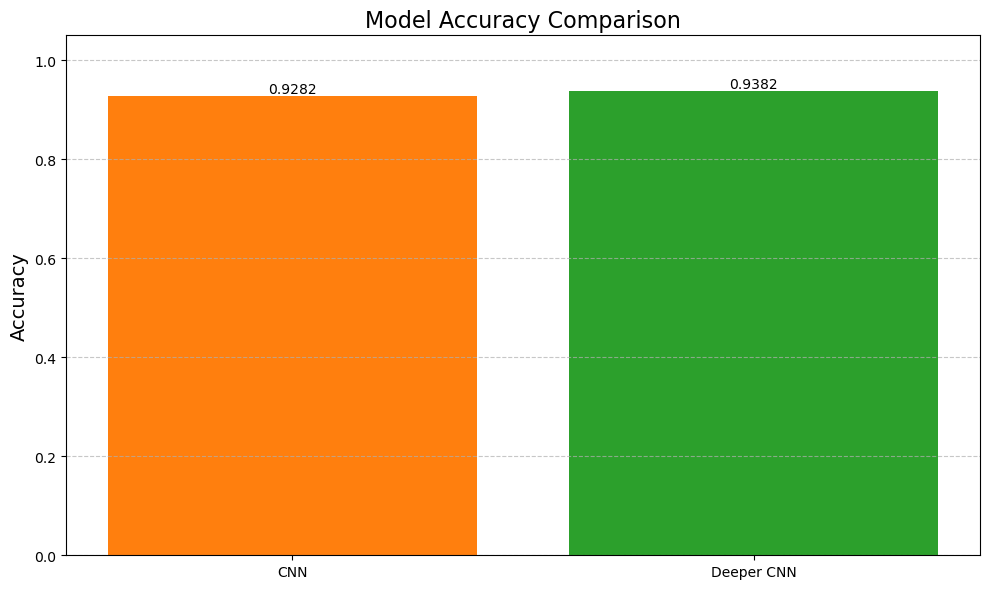

In [30]:
models = ['CNN', 'Deeper CNN']
accuracies = []
simple_cnn_results = [x[1] for x in model_results if x[0] == "CNN"]
if simple_cnn_results:
    accuracies.append(simple_cnn_results[0])
else:
    print("Warning: No results found for 'Simple CNN'.")

deeper_cnn_results = [x[1] for x in model_results if x[0] == "Deeper CNN"]
if deeper_cnn_results:
    accuracies.append(deeper_cnn_results[0])
else:
    print("Warning: No results found for 'Deeper CNN'.")


plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['#ff7f0e', '#2ca02c'])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom')

plt.title('Model Accuracy Comparison', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('model_comparison.png') 
plt.show()

## 1. Overview  
Evaluation of three models for Arabic handwritten character recognition:  

| Model          | Type          | Key Characteristics               |
|----------------|---------------|------------------------------------|
| SVM            | Traditional   | HOG features + RBF kernel         |
| CNN            | Deep Learning | 2 Conv layers + 2 Dense layers    |
| Deeper CNN     | Deep Learning | 3 Conv layers + 2 Dense layers    |

---

## 2. Accuracy Comparison  

| Model          | Test Accuracy (%) | Validation Accuracy (%) | Training Time |
|----------------|-------------------|-------------------------|---------------|
| **SVM**        | 73.01             | -                       | Fast (2-5 min)|
| **CNN**        | 92.56             | 92.82                   | Moderate (15-20 min) |
| **Deeper CNN** | 95.03             | 93.82                   | Long (25-35 min) |



---

## 3. Performance Analysis  

### SVM (Support Vector Machine)
- **Strengths**:  
  - Fast training  
  - Low computational requirements  
- **Limitations**:  
  - Struggles with similar-shaped characters   
  - Accuracy plateau at ~73%

### CNN (2-Layer)
- **Strengths**:  
  - 20% more accurate than SVM  
  - Balances speed and performance  
- **Limitations**:  
  - Occasionally confuses characters with diacritics

### Deeper CNN (3-Layer)
- **Strengths**:  
  - Highest accuracy (95%)  
  - Best for complex character variations  
- **Limitations**:  
  - 2× longer training time vs simple CNN  
  - Requires more GPU resources  

---



## 5. Recommendations  

### For Different Use Cases:  
| Scenario               | Recommended Model | Reason                |
|------------------------|-------------------|-----------------------|
| Quick prototyping      | SVM               | Fastest implementation|
| Production deployment  | Deeper CNN        | Highest accuracy      |
| Mobile/Edge devices    | CNN               | Balance of speed/accuracy |



## 6. Conclusion  
The Deeper CNN achieves the highest accuracy (95%) but requires more resources. For most applications:  
- **Choose CNN** for balanced performance  
- **Use Deeper CNN** when accuracy is critical  
- **Consider SVM** only for rapid prototyping  

---


In [31]:
model_path = 'best_arabic_char_cnn_model.h5'
best_model.save(model_path)
print(f"\nBest model saved to {model_path}")
def load_and_predict(model_path, new_data):
    if not os.path.exists(model_path):
        print("Model file not found!")
        return None
    
    model = load_model(model_path)
    new_data_norm = (new_data.reshape(-1, 32, 32, 1) / 255.0).astype(np.float32)
    predictions = model.predict(new_data_norm)
    predicted_classes = np.argmax(predictions, axis=1)
    return [arabic_letters[i] for i in predicted_classes]


Best model saved to best_arabic_char_cnn_model.h5


In [32]:
print("\nExample predictions on test samples:")
sample_data = X_test[:5]
predicted_letters = load_and_predict(model_path, sample_data)
true_letters = [arabic_letters[i] for i in y_test_0indexed[:5]]

for i, (pred, true) in enumerate(zip(predicted_letters, true_letters)):
    print(f"Sample {i+1}: Predicted='{pred}', Actual='{true}'")


Example predictions on test samples:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Sample 1: Predicted='ا', Actual='ا'
Sample 2: Predicted='ا', Actual='ا'
Sample 3: Predicted='ب', Actual='ب'
Sample 4: Predicted='ب', Actual='ب'
Sample 5: Predicted='ت', Actual='ت'



Testing on sample images from test set:

--- Test Sample 1 ---
Image index in test set: 1853
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


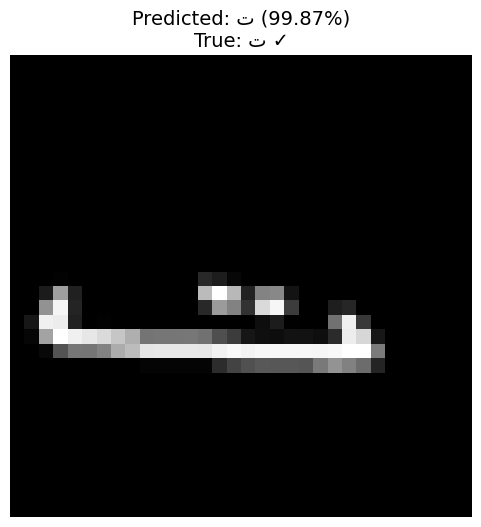


--- Test Sample 2 ---
Image index in test set: 2249
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


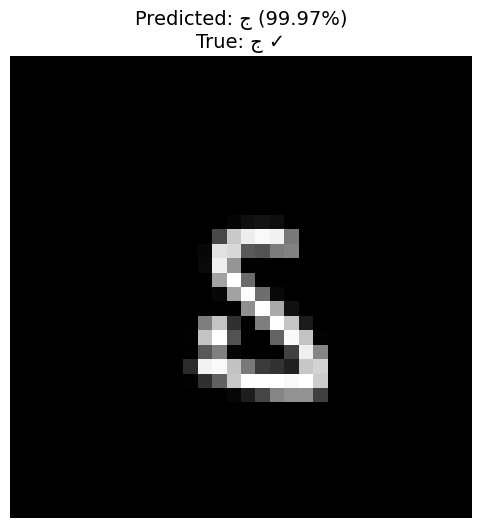


--- Test Sample 3 ---
Image index in test set: 2862


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


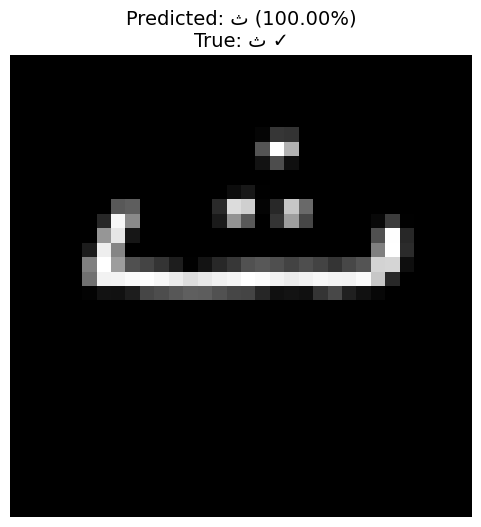

In [33]:
def predict_and_show_single_image(model_path, image_data, true_label=None):

    if not os.path.exists(model_path):
        print("Model file not found!")
        return
    model = load_model(model_path)
    

    img_normalized = (image_data.reshape(1, 32, 32, 1) / 255.0).astype(np.float32)
    
    prediction = model.predict(img_normalized)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)
    plt.figure(figsize=(6, 6))
    img = image_data.reshape(32, 32)
    img = np.flipud(img).T  
    plt.imshow(img, cmap='gray')
    title = f"Predicted: {arabic_letters[predicted_class]} ({confidence:.2%})"
    if true_label is not None:
        title += f"\nTrue: {arabic_letters[true_label]}"
        correct = "✓" if predicted_class == true_label else "✗"
        title += f" {correct}"
    
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.show()
print("\nTesting on sample images from test set:")
for i in range(3):  # Test 3 random samples
    idx = np.random.randint(len(X_test))
    print(f"\n--- Test Sample {i+1} ---")
    print(f"Image index in test set: {idx}")
    test_image = X_test[idx]
    true_label = y_test_0indexed[idx]  
    predict_and_show_single_image('best_arabic_char_cnn_model.h5', 
                                test_image, 
                                true_label)